In [2]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import plotly.express as px

from skimage.transform import hough_ellipse
from skimage.feature import canny
from skimage.draw import ellipse_perimeter

In [3]:
path_before = '../data/przed_operacja/out_nerka_Moving2_SPLINE.mhd'
path_after = '../data/po/out_nerka_Moving2_SPLINE.mhd'

image_before = sitk.ReadImage(path_before, sitk.sitkFloat32)
image_after = sitk.ReadImage(path_after, sitk.sitkFloat32)

In [4]:
path_seg_before = '../data/przed_operacja/TOTAL.mhd'
path_seg_after = '../data/po/TOTAL.mhd'

seg_before = sitk.ReadImage(path_seg_before)
seg_after = sitk.ReadImage(path_seg_after)

In [5]:
viewer = sitk.ImageViewer()
# ! this is for MacOS only, change it for your OS
command = '/Applications/Slicer.app/Contents/MacOS/Slicer'
viewer.SetCommand(command)

In [6]:
# viewer.Execute(sitk.LabelOverlay(image_after, seg_after))

### Breakdown after operation

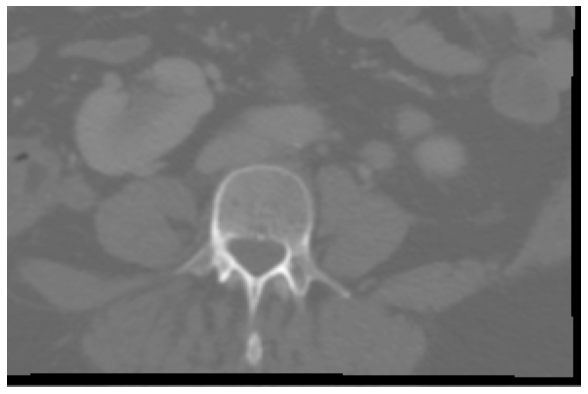

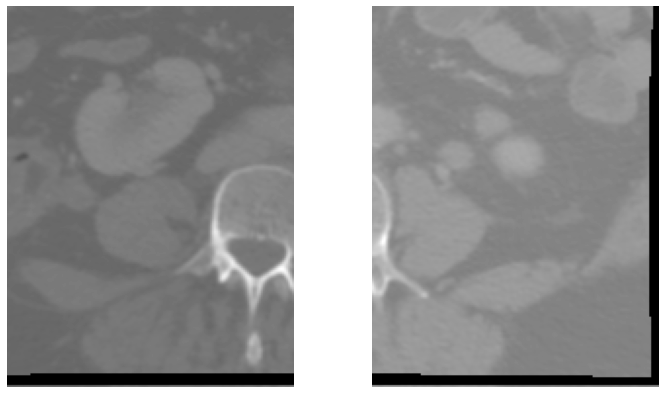

In [7]:
after_arr = sitk.GetArrayFromImage(image_after)
plt.figure(figsize=(12,7))
plt.imshow(after_arr[70], cmap='gray')
plt.axis('off')
plt.show()

half = after_arr.shape[2] // 2

left_after = after_arr[:,:,:half]
right_after = after_arr[:,:,half:]

seg_after_arr = sitk.GetArrayFromImage(seg_after)
left_seg_after = seg_after_arr[:,:,:half]
right_seg_after = seg_after_arr[:,:,half:]

plot, ax = plt.subplots(1, 2, figsize=(12, 7))

ax[0].imshow(left_after[70], cmap='gray')
ax[0].axis('off')
ax[1].imshow(right_after[70], cmap='gray')
ax[1].axis('off')
plt.show()

#### Voxel method (based on segmentation)

In [8]:
def voxels_volume(sitk_image, seg_slices):
    voxels = 0
    voxel_volume = 1

    for spacing in sitk_image.GetSpacing():
        voxel_volume *= spacing

    for seg_slice in seg_slices:
        # 1 stands for kindey
        values, counts = np.unique(seg_slice, return_counts=True)
        val_dict = dict(zip(values, counts))
        
        try:
            voxels +=  val_dict[1]
        except KeyError:
            pass
    
    volume = voxels * voxel_volume
    return volume


In [9]:
voxels_volume(image_after, left_seg_after)

113404.65467553

In [10]:
voxels_volume(image_after, right_seg_after)

126186.51861806399

#### Elipsoid method

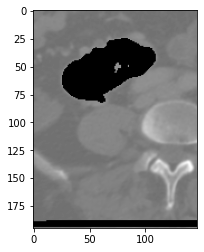

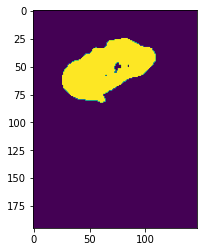

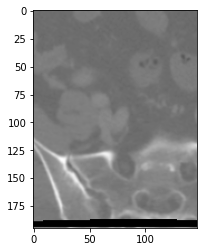

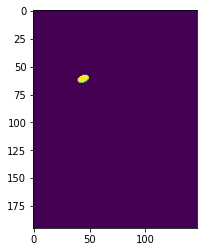

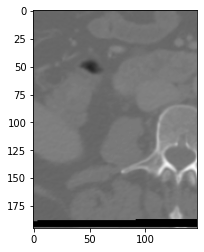

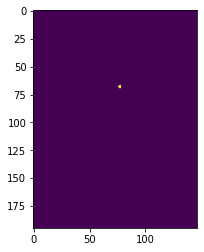

In [30]:
max_idx = None
first_idx = 158
last_idx = 0
max_counts = 0

for idx, seg_slice in enumerate(left_seg_after):
    mask = seg_slice == 1
    _, counts = np.unique(mask, return_counts=True)
    if len(counts) > 1:
        if counts[1] > max_counts:
            max_counts = counts[1]
            max_idx = idx
        if idx < first_idx:
            first_idx = idx
        if idx > max_idx:
            last_idx = idx

plt.imshow(left_after[max_idx, :, :], cmap='gray')
plt.show() 
plt.imshow(left_seg_after[max_idx, :, :] == 1)
plt.show()

plt.imshow(left_after[first_idx, :, :], cmap='gray')
plt.show()
plt.imshow(left_seg_after[first_idx, :, :] == 1)
plt.show()

plt.imshow(left_after[last_idx, :, :], cmap='gray')
plt.show()
plt.imshow(left_seg_after[last_idx, :, :] == 1)
plt.show()

## Trying the straightforward approach

In [12]:
max_left_seg = (left_seg_after[max_idx, :, :] == 1).astype(np.uint8)
max_left_seg *= 255
contour, hierarchy = cv.findContours(max_left_seg, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [13]:
left_after[max_idx].shape

(195, 147)

In [19]:
 image_with_contours = cv.drawContours(left_after[max_idx], contour, 1, (0, 255, 0), 1)
 contours_im = np.zeros_like(image_with_contours)
 contours_im[image_with_contours == 0] = 1

In [22]:
px.imshow(max_left_seg)

In [23]:
# edges = canny(left_seg_after[max_idx, :, :])
edges = canny(max_left_seg)
px.imshow(edges)

In [24]:
result = hough_ellipse(
    edges,
    # accuracy=20,
    # threshold=250,
    min_size=35,
    # max_size=200
)
len(result)

1

In [25]:
edges2 = np.copy(max_left_seg)

result.sort(order='accumulator')
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]


for param in result[-1:]: 
    param = list(param)
    yc, xc, a, b = [int(round(x)) for x in param[1:5]]
    orientation = param[5]
    xs, ys = ellipse_perimeter(yc, xc, a, b, orientation)

    try:
        edges2[xs, ys] = 100
    except IndexError:
        # print(np.unique(xs))
        # print(np.unique(ys))
        pass

px.imshow(edges2)

In [28]:
last_idx

0

In [32]:
c = last_idx - first_idx
volume = a * b * c * np.pi * (2 / 3)
volume

130135.23968720119

## Least squares fit to 3D ellipsoid

In [18]:
# Method from: http://www.juddzone.com/ALGORITHMS/least_squares_3D_ellipsoid.html

import numpy as np
from numpy.linalg import eig, inv

#least squares fit to a 3D-ellipsoid
#  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz  = 1
#
# Note that sometimes it is expressed as a solution to
#  Ax^2 + By^2 + Cz^2 + 2Dxy + 2Exz + 2Fyz + 2Gx + 2Hy + 2Iz  = 1
# where the last six terms have a factor of 2 in them
# This is in anticipation of forming a matrix with the polynomial coefficients.
# Those terms with factors of 2 are all off diagonal elements.  These contribute
# two terms when multiplied out (symmetric) so would need to be divided by two

def ls_ellipsoid(xx,yy,zz):

   # change xx from vector of length N to Nx1 matrix so we can use hstack
   x = xx[:,np.newaxis]
   y = yy[:,np.newaxis]
   z = zz[:,np.newaxis]

   #  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz = 1
   J = np.hstack((x*x,y*y,z*z,x*y,x*z,y*z, x, y, z))
   K = np.ones_like(x) #column of ones

   #np.hstack performs a loop over all samples and creates
   #a row in J for each x,y,z sample:
   # J[ix,0] = x[ix]*x[ix]
   # J[ix,1] = y[ix]*y[ix]
   # etc.

   JT=J.transpose()
   JTJ = np.dot(JT,J)
   InvJTJ=np.linalg.inv(JTJ);
   ABC= np.dot(InvJTJ, np.dot(JT,K))

# Rearrange, move the 1 to the other side
#  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz - 1 = 0
#    or
#  Ax^2 + By^2 + Cz^2 +  Dxy +  Exz +  Fyz +  Gx +  Hy +  Iz + J = 0
#  where J = -1
   eansa=np.append(ABC,-1)

   return (eansa)

In [20]:
def polyToParams3D(vec,printMe):

   # convert the polynomial form of the 3D-ellipsoid to parameters
   # center, axes, and transformation matrix
   # vec is the vector whose elements are the polynomial
   # coefficients A..J
   # returns (center, axes, rotation matrix)

   #Algebraic form: X.T * Amat * X --> polynomial form

   if printMe: print('\npolynomial\n %s',vec)

   Amat=np.array(
   [
   [ vec[0],     vec[3]/2.0, vec[4]/2.0, vec[6]/2.0 ],
   [ vec[3]/2.0, vec[1],     vec[5]/2.0, vec[7]/2.0 ],
   [ vec[4]/2.0, vec[5]/2.0, vec[2],     vec[8]/2.0 ],
   [ vec[6]/2.0, vec[7]/2.0, vec[8]/2.0, vec[9]     ]
   ])

   if printMe: print('\nAlgebraic form of polynomial\n %s', Amat)

   #See B.Bartoni, Preprint SMU-HEP-10-14 Multi-dimensional Ellipsoidal Fitting
   # equation 20 for the following method for finding the center
   A3=Amat[0:3,0:3]
   A3inv=inv(A3)
   ofs=vec[6:9]/2.0
   center=-np.dot(A3inv,ofs)
   if printMe: print('\nCenter at: %s',center)

   # Center the ellipsoid at the origin
   Tofs=np.eye(4)
   Tofs[3,0:3]=center
   R = np.dot(Tofs,np.dot(Amat,Tofs.T))
   if printMe: print('\nAlgebraic form translated to center\n %s', R,)

   R3=R[0:3,0:3]
   R3test=R3/R3[0,0]
   print('normed \n %s', R3test)
   s1=-R[3, 3]
   R3S=R3/s1
   (el,ec)=eig(R3S)

   recip=1.0/np.abs(el)
   axes=np.sqrt(recip)
   if printMe: print('\nAxes are\n %s', axes)

   inve=inv(ec) #inverse is actually the transpose here
   if printMe: print('\nRotation matrix\n %s', inve)
   return (center,axes,inve)

In [ ]:
# select points

In [31]:
result = ls_ellipsoid(*np.nonzero(left_seg_after == 1))
result

array([-1.54739512e-05, -1.43322008e-04, -4.99113079e-05,  4.19565284e-05,
        2.52944713e-05, -1.54463684e-04, -2.13099048e-03,  2.36287781e-02,
        1.34570729e-02, -1.00000000e+00])

In [30]:
polyToParams3D(result, True)


polynomial
 %s [-1.54739512e-05 -1.43322008e-04 -4.99113079e-05  4.19565284e-05
  2.52944713e-05 -1.54463684e-04 -2.13099048e-03  2.36287781e-02
  1.34570729e-02 -1.00000000e+00]

Algebraic form of polynomial
 %s [[-1.54739512e-05  2.09782642e-05  1.26472356e-05 -1.06549524e-03]
 [ 2.09782642e-05 -1.43322008e-04 -7.72318419e-05  1.18143890e-02]
 [ 1.26472356e-05 -7.72318419e-05 -4.99113079e-05  6.72853645e-03]
 [-1.06549524e-03  1.18143890e-02  6.72853645e-03 -1.00000000e+00]]

Center at: %s [59.28321601 62.40871713 53.26177968]

Algebraic form translated to center
 %s [[-1.54739512e-05  2.09782642e-05  1.26472356e-05  4.77048956e-18]
 [ 2.09782642e-05 -1.43322008e-04 -7.72318419e-05 -3.46944695e-18]
 [ 1.26472356e-05 -7.72318419e-05 -4.99113079e-05 -2.60208521e-18]
 [ 4.77048956e-18 -3.46944695e-18 -2.60208521e-18  3.25287054e-02]]
normed 
 %s [[ 1.         -1.35571477 -0.81732425]
 [-1.35571477  9.26214681  4.99108733]
 [-0.81732425  4.99108733  3.22550505]]

Axes are
 %s [13.074097

(array([59.28321601, 62.40871713, 53.26177968]),
 array([13.07409759, 51.78295057, 72.00262511]),
 array([[ 0.13870238, -0.86237232, -0.48690413],
        [-0.98300766, -0.17958065,  0.03803599],
        [ 0.12023974, -0.47335481,  0.87262686]]))

In [32]:
(4 / 3) * np.pi * result[0] * result[1] * result[2]

-4.636621745170086e-13